# Introduction

Model regularization in supervised machine learning refers to a set of techniques used to prevent overfitting, which occurs when a model learns not only the underlying patterns in the training data but also the noise. Overfitting leads to poor generalization to unseen data (e.g., a test set).

Regularization techniques modify the loss function (the function minimized during training) to penalize complexity in the model, typically by discouraging large parameter values or overly complex structures.

Without regularization, a flexible model (like a high-degree polynomial or deep neural net) can memorize the training data, resulting in **low training error but high test error**. Regularization helps in finding a **simpler model** that generalizes better.

### Common Regularization Techniques:

- **L1 Regularization (Lasso)**
- **L2 Regularization (Ridge)**
- **Elastic Net**
- Early Stopping (for Gradient-based methods)
- Dropout (for Neural Networks)

# Lasso (L1)

O LASSO (*Least Absolute Shrinkage and Selection Operator*) é um modelo linear que estima vetores de coeficientes *esparsos*. Essa variante é útil em alguns contextos devido à sua tendência de preferir soluções com menos coeficientes diferentes de zero, reduzindo efetivamente o número de atributos dos quais o modelo ajustado depende.

Do ponto de vista da otimização, a função de custo é modificada conforme a seguir:
$$
\mathcal{L}_{\text{L1}} = \text{Loss} + \lambda \sum_j \mid\theta_j\mid
$$

Por exemplo, a regularização Lasso aplicada à  regressão procura minimizar a seguinte função durante o treinamento: 
$$
J(\theta) = \frac{1}{2m} \left[ \sum_{i=1}^m \left(h_\theta (x^{(i)}) - y^{(i)}\right)^2 \right] + \lambda \sum_{j=1}^{n} \mid \theta_j \mid
$$


## Example: regularized linear regression

Imagine you're trying to predict a student's final grade based on 5 possible features:

- `hours_studied`

- `attendance_rate`

- `number_of_snacks_eaten`

- `shoe_size`

- `favorite_color_code`

Clearly, only the first two features are relevant. Lasso can help to automatically ignore the irrelevant ones.

               Feature  Lasso Coefficient
0        hours_studied           2.487471
1      attendance_rate          -1.687187
2         snacks_eaten          -0.000000
3            shoe_size           0.000000
4  favorite_color_code           0.000000


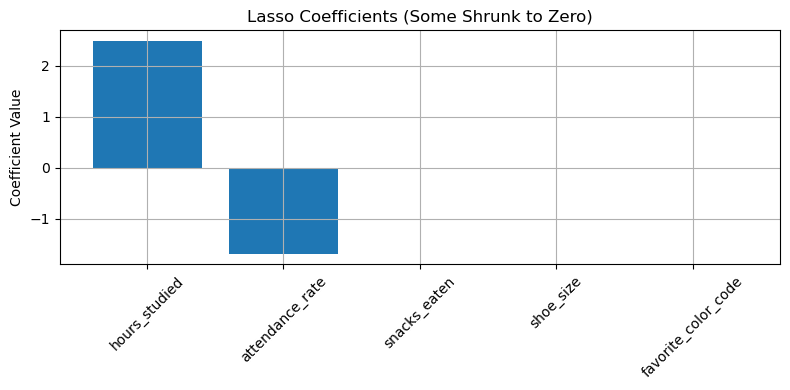

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
import pandas as pd

# Simulated data
np.random.seed(42)
n_samples = 30

# Only the first 2 features are truly predictive
X = np.random.randn(n_samples, 5)
true_coefs = np.array([2.5, -1.8, 0.0, 0.0, 0.0])
y = X @ true_coefs + np.random.randn(n_samples) * 0.5

# Fit Lasso model
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)

# Show coefficients
feature_names = ["hours_studied", "attendance_rate", "snacks_eaten", "shoe_size", "favorite_color_code"]
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Lasso Coefficient": lasso.coef_
})

print(coef_df)

# Plot
plt.figure(figsize=(8, 4))
plt.bar(feature_names, lasso.coef_)
plt.title("Lasso Coefficients (Some Shrunk to Zero)")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## Example: regularized logistic regression

In [14]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

X, y = load_iris(return_X_y=True)
clf = LogisticRegression(penalty="l1", solver="liblinear", C=0.1)
clf.fit(X, y == 0)  # binary classification (e.g., class 0 vs others)

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
print("Original shape:", X.shape)
print("Reduced shape:", X_new.shape)

Original shape: (150, 4)
Reduced shape: (150, 2)


### Interpretation

Lasso assigns non-zero weights only to meaningful features (hours_studied, attendance_rate). The irrelevant features get a coefficient of zero — as if they were removed from the model. This is what makes Lasso great for feature selection, especially when you have many features but only a few matter.



### Lasso x SelectFromModel
The follwoing code ([source](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel)) demonstrates how to use **Lasso regression for feature selection** on the Iris dataset. It first loads the dataset, then fits a `Lasso` model to predict the target variable from the input features. Because Lasso can shrink some coefficients to exactly zero, the `SelectFromModel` utility is then used to automatically select only those features with non-zero coefficients. The `transform` method is applied to the original feature matrix `X`, resulting in a reduced feature set `X_new` that retains only the selected features. The printed shapes show the number of features before and after selection, highlighting Lasso's ability to perform **dimensionality reduction** by filtering out less informative features.

In [8]:
from sklearn.linear_model import Lasso
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

iris = load_iris()
X, y = iris.data, iris.target
print(X.shape)

lassoreg = Lasso(alpha=0.01).fit(X, y)
model = SelectFromModel(lassoreg, prefit=True)
X_new = model.transform(X)
print(X_new.shape)

(150, 4)
(150, 3)


# Ridge (L2)

A classe Ridge do Scikit-Learn implementa a regularização Ridge. Essa classe possui um hiperparâmetro denominado `alfa`, que corresponde ao hiperparâmetro denominado *termo de regularização*. O hiperparâmetro `alfa` permite controlar o quanto penalizamos os coeficientes. Valores altos de `alfa` resultam na criação de modelos mais simples. O valor ideal de `alpha` deve ser ajustado como qualquer outro hiperparâmetro, por meio da seleção de modelo (*model selection*). 

Do ponto de vista da otimização, a função de custo é modificada conforme a seguir:
$$
\mathcal{L}_{\text{L2}} = \text{Loss} + \lambda \sum_j (\theta_j)^2
$$

No contexto de um problema de regressão linear, a regularização Ridge corresponde a adicionar uma parcela à função de custo, conforme abaixo.

$$
\begin{align}
\min_{\Theta} J(\Theta) &= \min_{\Theta} || X \Theta - y||_2^2 + \alpha ||\Theta||_2^2 \\ &= \min_{\Theta} \frac{1}{2m} \left[ \sum _{i=1}^m \left (h_\theta (x^{(i)}) - y^{(i)} \right)^2 + {\alpha\sum_{j=1}^{n} \theta_j^{2}} \right]
\end{align}
$$


The following code ([source](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols_ridge_variance.html)) illustrates the **effect of regularization on the stability of linear models** by comparing ordinary least squares (OLS) regression with Ridge regression. It trains both models multiple times on slightly perturbed versions of a small training dataset consisting of two points, introducing random noise to simulate variability in the input. For each model (OLS and Ridge), it plots the resulting fitted lines from the noisy datasets in gray to show how much the model's predictions vary. Finally, it retrains the model on the original data and overlays the resulting prediction line in blue, along with the original training points in red. The visual comparison reveals that **Ridge regression produces more stable and less variable predictions** than OLS due to its regularization term, which constrains the model coefficients.

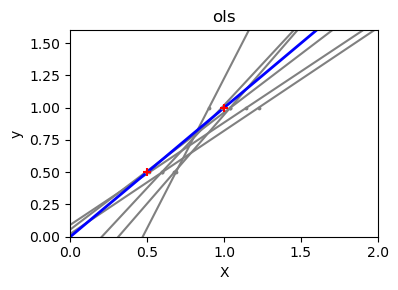

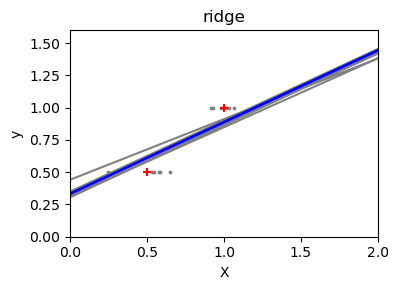

In [9]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model

X_train = np.c_[0.5, 1].T
y_train = [0.5, 1]
X_test = np.c_[0, 2].T

np.random.seed(0)

classifiers = dict(
    ols=linear_model.LinearRegression(), ridge=linear_model.Ridge(alpha=0.1)
)

for name, clf in classifiers.items():
    fig, ax = plt.subplots(figsize=(4, 3))

    for _ in range(6):
        this_X = 0.1 * np.random.normal(size=(2, 1)) + X_train
        clf.fit(this_X, y_train)

        ax.plot(X_test, clf.predict(X_test), color="gray")
        ax.scatter(this_X, y_train, s=3, c="gray", marker="o", zorder=10)

    clf.fit(X_train, y_train)
    ax.plot(X_test, clf.predict(X_test), linewidth=2, color="blue")
    ax.scatter(X_train, y_train, s=30, c="red", marker="+", zorder=10)

    ax.set_title(name)
    ax.set_xlim(0, 2)
    ax.set_ylim((0, 1.6))
    ax.set_xlabel("X")
    ax.set_ylabel("y")

    fig.tight_layout()

plt.show()

Another simple example:

               Feature  Lasso Coefficient  Ridge Coefficient
0        hours_studied           2.487471           2.567770
1      attendance_rate          -1.687187          -1.793055
2         snacks_eaten          -0.000000          -0.059073
3            shoe_size           0.000000           0.015725
4  favorite_color_code           0.000000           0.063610


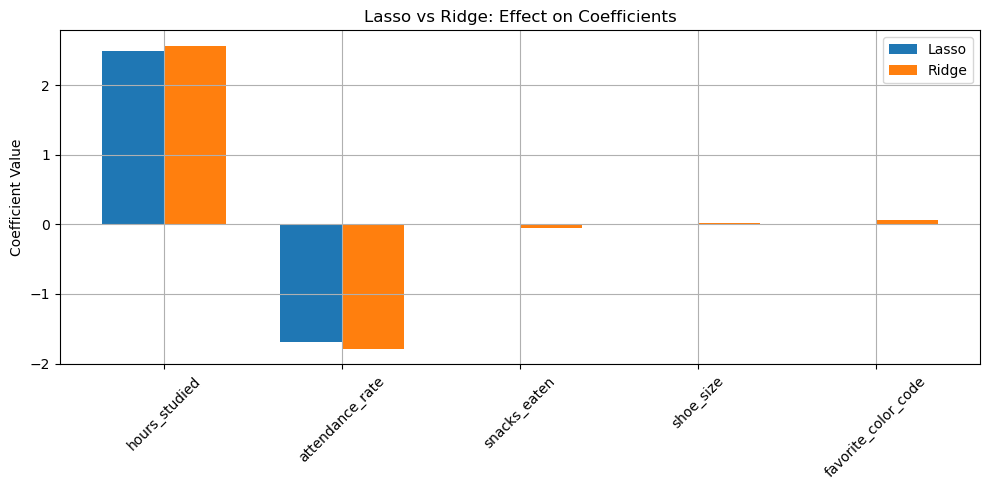

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
import pandas as pd

# Simulated data
np.random.seed(42)
n_samples = 30

# Only the first 2 features are meaningful
X = np.random.randn(n_samples, 5)
true_coefs = np.array([2.5, -1.8, 0.0, 0.0, 0.0])
y = X @ true_coefs + np.random.randn(n_samples) * 0.5

# Fit both models
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=0.1)

lasso.fit(X, y)
ridge.fit(X, y)

# Prepare coefficient table
feature_names = ["hours_studied", "attendance_rate", "snacks_eaten", "shoe_size", "favorite_color_code"]

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Lasso Coefficient": lasso.coef_,
    "Ridge Coefficient": ridge.coef_
})

print(coef_df)

# Plot side-by-side comparison
x = np.arange(len(feature_names))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, lasso.coef_, width, label='Lasso')
plt.bar(x + width/2, ridge.coef_, width, label='Ridge')
plt.xticks(x, feature_names, rotation=45)
plt.ylabel("Coefficient Value")
plt.title("Lasso vs Ridge: Effect on Coefficients")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

O exemplo de código a seguir ([fonte](https://chrisalbon.com/machine_learning/linear_regression/effect_of_alpha_on_lasso_regression/)) ilustra o efeito de diferentes valores do hiperparâmetro de regularização sobre o modelo resultante. Repare que, diferente da regularização Ridge (que tende a produzir uma vetor de coeficientes com entradas pequenas em magnitude, mas diferentes de zero), a regularização LASSO tente a produzir uma vetor de coeficientes esparso.

In [11]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import pandas as pd

X = df_housing.drop(columns=['median_house_value', 'ocean_proximity'])
names = X.columns
y = df_housing.median_house_value

scaler = StandardScaler()
X = scaler.fit_transform(X)

def run_lasso_regression(alphas):
    '''
    Takes in a list of alphas. 
    Outputs a dataframe containing the coefficients of lasso regressions from each alpha.
    '''
    # Create an empty data frame
    df = pd.DataFrame()
    
    # Create a column of feature names
    df['Feature Name'] = names
    
    # For each alpha value in the list of alpha values,
    for alpha in alphas:
        # Create a lasso regression with that alpha value,
        lasso = Lasso(alpha=alpha)
        
        # Fit the lasso regression
        lasso.fit(X, y)
        
        # Create a column name for that alpha value
        column_name = 'Alpha = %f' % alpha

        # Create a column of coefficient values
        df[column_name] = lasso.coef_
        
    # Return the datafram    
    return df

run_lasso_regression([.0001, .5, 10])

,Feature Name,Alpha = 0.000100,Alpha = 0.500000,Alpha = 10.000000
0,longitude,-85611.028551,-85605.720929,-85504.824216
1,latitude,-90813.353983,-90808.220317,-90710.608224
2,housing_median_age,14579.698391,14580.002999,14585.795835
3,total_rooms,-18027.430124,-18018.157315,-17842.277024
4,total_bedrooms,47961.171050,47951.486325,47768.061268
5,population,-43497.797845,-43494.577675,-43433.195625
6,households,18235.742983,18233.474434,18189.898229
7,median_income,76534.857095,76532.988917,76497.568678


Para uma intuição gráfica do efeito do hiperparâmetro $alpha$, considere a figura abaixo ([fonte](https://scikit-learn.org/stable/modules/linear_model.html)). Nessa figura, cada linha corresponde ao valor de ums dos coeficientes. Repare que $\alpha$ controla a quantidade de encolhimento (*shrinkage*) aplicada aos coeficientes: quanto maior o valor de $\alpha$, maior a quantidade de encolhimento e, portanto, os coeficientes se tornam mais robustos à colinearidade.

![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_ridge_path_001.png)

# L1 x L2

The code below generates synthetic training data by sampling points from a noisy sine function and fits three polynomial regression models of degree 15: 
- one without regularization (ordinary least squares, OLS), 
- one with L2 regularization (Ridge), 
- one with L1 regularization (Lasso). 

It uses scikit-learn's `Pipeline` to first expand the input features using `PolynomialFeatures`, then apply the respective regression method. After fitting each model to the training data, it evaluates them on a dense test grid and visualizes the predicted curves alongside the true sine function and the training data. The resulting plot illustrates how OLS may overfit with a high-degree polynomial, while Ridge and Lasso regularization help smooth the model predictions and reduce overfitting.

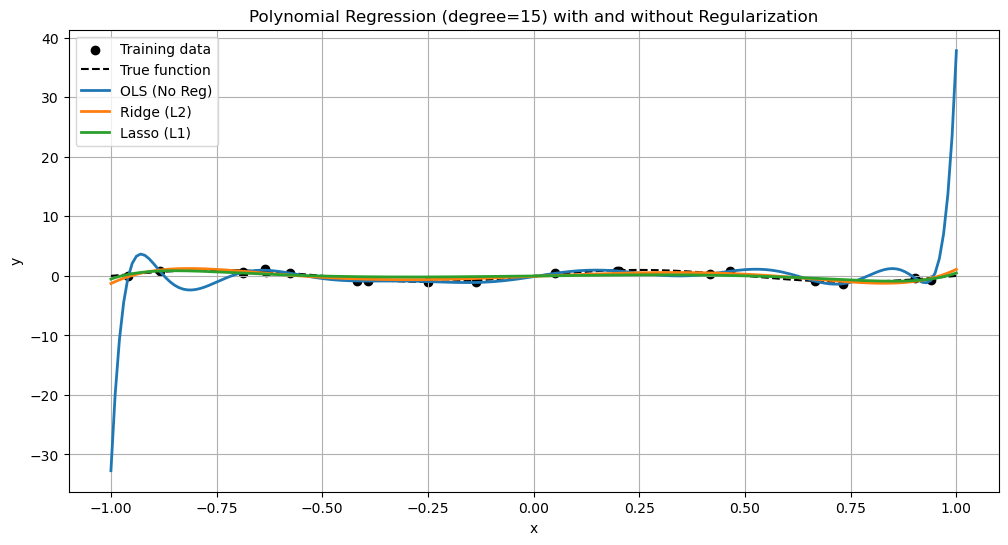

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Generate synthetic data (noisy sine wave)
np.random.seed(42)
X = np.sort(np.random.rand(20, 1) * 2 - 1, axis=0)  # Range [-1, 1]
y = np.sin(2 * np.pi * X[:, 0]) + 0.3 * np.random.randn(20)

# Polynomial degree
degree = 15

# Define models
ols_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
ridge_model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1e-2))
lasso_model = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=1e-2, max_iter=10000))

# Fit models
ols_model.fit(X, y)
ridge_model.fit(X, y)
lasso_model.fit(X, y)

# Prediction grid
x_test = np.linspace(-1, 1, 200).reshape(-1, 1)
ols_pred = ols_model.predict(x_test)
ridge_pred = ridge_model.predict(x_test)
lasso_pred = lasso_model.predict(x_test)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(X, y, color='black', label='Training data')
plt.plot(x_test, np.sin(2 * np.pi * x_test), 'k--', label='True function')
plt.plot(x_test, ols_pred, label='OLS (No Reg)', linewidth=2)
plt.plot(x_test, ridge_pred, label='Ridge (L2)', linewidth=2)
plt.plot(x_test, lasso_pred, label='Lasso (L1)', linewidth=2)
plt.title(f'Polynomial Regression (degree={degree}) with and without Regularization')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Elastic-Net

O ElasticNet é um modelo de regressão linear regularizado que é treinado por meio da combinação das regularizações Ridge e Lasso. Essa combinação permite aprender um modelo esparso, em que poucos pesos são diferentes de zero como Lasso, mantendo as propriedades de regularização do Ridge. 

Matematicamente, a regularização ElasticNet procura minimizar a função de custo a seguir durante o treinamento do modelo:
$$
\min_{\Theta} { \frac{1}{2m} ||X \Theta - y||_2 ^ 2 + \alpha \rho ||\Theta||_1 +
\frac{\alpha(1-\rho)}{2} ||\Theta||_2 ^ 2}
$$

O valor do hiperparâmetro $\rho$ controla a combinação convexa.

O ElasticNet é útil quando existem vários atributos correlacionados entre si. Nessas situações, é provável que o Lasso escolha um deles aleatoriamente, enquanto a rede elástica provavelmente escolha ambos.

No Scikit-learn a classe [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) implemente esse tipo de regularização. O hiperparâmetros $\rho$ é representados pelo parâmetro `l1_ratio` (cujo valor *default* é 0.5). Veja o exemplo a seguir ([fonte](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet)).


In [13]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression

X, y = make_regression(n_features=2, random_state=0)
regr = ElasticNet(random_state=0)
regr.fit(X, y)  

print(regr.coef_) 
print(regr.intercept_) 
print(regr.predict([[0, 0]])) 

[18.83816048 64.55968825]
1.4512607561654027
[1.45126076]


# Summary

| Regularization Type | Penalty Term | Effect on Weights         | When to Use                                 | Loss Function |
|---------------------|--------------|----------------------------|----------------------------------------------|---------------|
| **L1 (Lasso)**       | Absolute value ($\sum_i \mid\theta_i\mid$) | Promotes sparsity (some weights become 0)   | When you want feature selection (sparse models) | $\mathcal{L}_{\text{L1}} = \text{Loss} + \lambda \sum_i \mid\theta_i\mid$ |
| **L2 (Ridge)**       | Square ($\sum_i \theta_i^2$)         | Shrinks weights but rarely to exactly zero  | When all features are useful but need regularization | $\mathcal{L}_{\text{L2}} = \text{Loss} + \lambda \sum_i \theta_i^2$ |
| **Elastic Net**      | Combination of L1 and L2             | Balances sparsity and shrinkage             | When there are many correlated features             | $\mathcal{L}_{\text{EN}} = \text{Loss} + \lambda_1 \sum_i \mid\theta_i\mid + \lambda_2 \sum_i \theta_i^2$ |

# References
1. [What does sklearn "RidgeClassifier" do?](https://stackoverflow.com/questions/53911663/what-does-sklearn-ridgeclassifier-do)
2. [Lasso & Ridge Regression | A Comprehensive Guide in Python & R (Updated 2024)](https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/)
3. [L2 Regularization is Much More Magical That Most People Think](https://blog.dailydoseofds.com/p/l2-regularization-is-much-more-magical)
4. [The Probabilistic Origin of Regularization](https://www.dailydoseofds.com/the-origin-of-regularization/)